# Libraries

In [1]:
import calendar
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from IPython.core.display import display

from sklearn.cluster import KMeans

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_pinball_loss

# Data read in

In [2]:
file_path1 = "monthly_sales.xlsx"
file_path2 = "SKU Attributes Report.xlsx"

df_monthly_sales = pd.read_excel(file_path1)
df_monthly_sales = df_monthly_sales.sort_values(by='Intro Date')

df_sku_attributes = pd.read_excel(file_path2)

In [3]:
df_items = df_monthly_sales[['Item']].copy()

# Split the DataFrame randomly
train_items, test_items = train_test_split(df_items, test_size=0.25, random_state=42)

# Display the shapes of the resulting DataFrames to verify the split
print("Training items shape:", train_items.shape)
print("Test items shape:", test_items.shape)

Training items shape: (518, 1)
Test items shape: (173, 1)


#SKU attributes

In [4]:
# Create a new DataFrame with the specified columns
df_demand_profile_sku_attributes = df_sku_attributes[[
  'Item',
  'Category',
  'Subcategory Desc',
  'CommGroup2 Desc',
  'Intro Month'
  ]]

In [5]:
# Create a new DataFrame with the specified columns
df_total_demand_sku_attributes = df_sku_attributes[[
  'Item',
  'Category',
  'Subcategory Desc',
  'CommGroup2 Desc',
  'Intro Month',
  'Brand',
  'Base Price'
  ]]

#Sales distribution

In [6]:
# Select the columns to normalize
cols_to_normalize = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Calculate the sum of the selected columns for each row
df_monthly_sales['Total_Sales'] = df_monthly_sales[cols_to_normalize].sum(axis=1)

# Normalize the selected columns by dividing by the total sales for each row
for col in cols_to_normalize:
    df_monthly_sales[col] = df_monthly_sales[col] / df_monthly_sales['Total_Sales']

# Drop the 'Total_Sales' column as it is no longer needed
df_monthly_sales.drop(columns=['Total_Sales'], inplace=True)

# Display the head of the modified DataFrame to show the normalized columns
display(df_monthly_sales.head())

Item Intro Date         1         2         3         4         5  \
43  101036-001 2022-01-01  0.169947  0.091215  0.079693  0.008321  0.000320   
45  101037-001 2022-01-01  0.002447  0.004544  0.213911  0.301293  0.003495   
58  101184-920 2022-01-01  0.000000  0.000000  0.000000  0.141957  0.576353   
57  101184-237 2022-01-01  0.001968  0.004427  0.000246  0.089769  0.108706   
56  101183-920 2022-01-01  0.000000  0.000434  0.000000  0.000434  0.190187   

           6         7         8         9        10        11        12  
43  0.000160  0.000960  0.018243  0.389662  0.210274  0.026884  0.004321  
45  0.000000  0.000000  0.000000  0.000000  0.034953  0.206222  0.233135  
58  0.001483  0.002595  0.000741  0.000371  0.001112  0.094144  0.181245  
57  0.291933  0.028283  0.034678  0.026316  0.198721  0.175848  0.039105  
56  0.000434  0.000000  0.000000  0.101172  0.223187  0.463309  0.020842

In [7]:
# Select the Item column and demand profile columns
columns_to_split = ['Item'] + [i for i in range(1, 13)]
df_split = df_monthly_sales[columns_to_split].dropna(subset=[i for i in range(1, 13)])

# Split the data into training and testing sets
train_df_demand_profiles = df_split[df_split['Item'].isin(train_items['Item'])].copy()
test_df_demand_profiles = df_split[df_split['Item'].isin(test_items['Item'])].copy()

# Display the shapes of the resulting dataframes to verify the split
print("Training set shape:", train_df_demand_profiles.shape)
print("Test set shape:", test_df_demand_profiles.shape)

Training set shape: (515, 13)
Test set shape: (173, 13)


In [8]:
test_df_demand_profiles.head()

Item         1         2         3         4         5         6  \
58  101184-920  0.000000  0.000000  0.000000  0.141957  0.576353  0.001483   
54  101182-130  0.002257  0.003868  0.000161  0.411992  0.168923  0.057382   
37  101033-001  0.001934  0.060606  0.023856  0.121642  0.424457  0.000860   
47  101038-001  0.001672  0.049816  0.171515  0.149894  0.113006  0.000000   
96  101285-000  0.000000  0.000062  0.000000  0.461918  0.050340  0.044352   

           7         8         9        10        11        12  
58  0.002595  0.000741  0.000371  0.001112  0.094144  0.181245  
54  0.000000  0.000000  0.056738  0.056093  0.155867  0.086718  
37  0.001075  0.000645  0.000645  0.059102  0.212121  0.093058  
47  0.000111  0.000557  0.089156  0.187005  0.093503  0.143765  
96  0.007111  0.000312  0.142599  0.185640  0.079596  0.028071

In [9]:
# Create the two-column DataFrame
train_df_demand_profiles = pd.DataFrame({
    "Item": train_df_demand_profiles["Item"],
    "Cluster": train_df_demand_profiles.loc[:, 1:12].values.tolist()
})

print(train_df_demand_profiles.head())

          Item                                            Cluster
43  101036-001  [0.1699471915506481, 0.09121459433509362, 0.07...
45  101037-001  [0.002446696959105208, 0.004543865781195386, 0...
57  101184-237  [0.001967535661583866, 0.004426955238563699, 0...
56  101183-920  [0.0, 0.0004342162396873643, 0.0, 0.0004342162...
55  101183-237  [0.0013726835964310226, 0.007206588881262869, ...


In [10]:
merged_df = pd.merge(train_df_demand_profiles, df_demand_profile_sku_attributes, on='Item', how='inner')

# Display the head of the merged DataFrame
display(merged_df.head())

Item                                            Cluster Category  \
0  101036-001  [0.1699471915506481, 0.09121459433509362, 0.07...     TOTE   
1  101037-001  [0.002446696959105208, 0.004543865781195386, 0...    TRAVL   
2  101184-237  [0.001967535661583866, 0.004426955238563699, 0...    OUTDR   
3  101183-920  [0.0, 0.0004342162396873643, 0.0, 0.0004342162...     TOTE   
4  101183-237  [0.0013726835964310226, 0.007206588881262869, ...     TOTE   

   Subcategory Desc       CommGroup2 Desc  Intro Month  
0             Event                 Promo            1  
1      Organization          Toiletry Bag            1  
2  Patio and Picnic  Cocktail Accessories            1  
3          Everyday           All Purpose            1  
4          Everyday           All Purpose            1

In [11]:
merged_df.drop(columns=['Item'], inplace=True)

In [12]:
merged_df['Intro Month'] = merged_df['Intro Month'].astype('category')

In [13]:
#Separating target variable and other variables
y_train = merged_df['Cluster']#write your code here
x_train = merged_df.drop(columns={'Cluster'})#write your code here

In [14]:
#Creating dummy variables
#drop_first=True is used to avoid redundant variables
x_train = pd.get_dummies(x_train, drop_first=True)

In [15]:
y_train = np.vstack(merged_df['Cluster'].values)

In [16]:
# Choose the type of classifier
tree = RandomForestRegressor()

# Fit the best algorithm to the data
tree.fit(x_train, y_train)

RandomForestRegressor()

<Axes: xlabel='Importance', ylabel='None'>

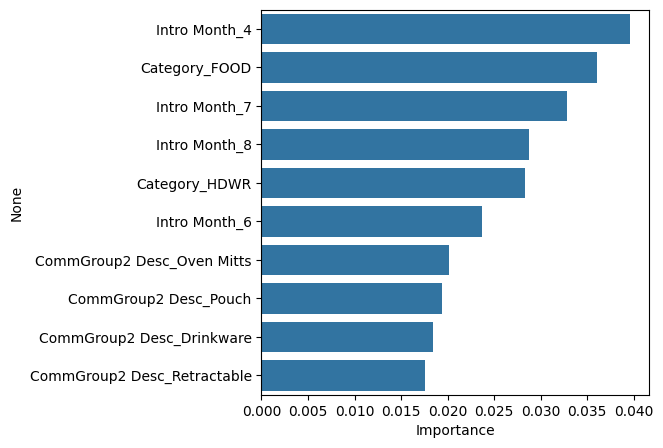

In [17]:
importances = tree.feature_importances_
columns=x_train.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(5,5))
sns.barplot(x=importance_df.Importance.head(10),y=importance_df.index[:10])

In [18]:
# Merge test demand profiles with SKU attributes
merged_test_df = pd.merge(test_df_demand_profiles, df_demand_profile_sku_attributes, on='Item', how='inner')

# Drop the 'Item' column
merged_test_df.drop(columns=['Item'], inplace=True)

# Convert 'Intro Month' to categorical
merged_test_df['Intro Month'] = merged_test_df['Intro Month'].astype('category')

# Create dummy variables
merged_test_df = pd.get_dummies(merged_test_df, drop_first=False)

# Separate target variable and other variables (assuming 'Cluster' is in the test data)
# Note: We don't have 'Cluster' in the original test_df_demand_profiles,
# so we'll only create x_test. If you have true labels for test data,
# you would create y_test similarly.
x_test = merged_test_df.copy()

# Align columns of test data with training data - this is crucial for consistent features
# Add missing columns in x_test that are present in x_train (fill with 0)
missing_cols = set(x_train.columns) - set(x_test.columns)
for c in missing_cols:
    x_test[c] = 0

# Drop columns in x_test that are not in x_train
extra_cols = set(x_test.columns) - set(x_train.columns)
x_test = x_test.drop(columns=extra_cols)

# Ensure the order of columns is the same
x_test = x_test[x_train.columns]

print("Prepared test data shape:", x_test.shape)

Prepared test data shape: (173, 172)


In [19]:
non_zero_count = (x_test != 0).sum().sum()
print(f"Number of non-zero values in x_test: {non_zero_count}")

Number of non-zero values in x_test: 627


### Test data predictions

In [20]:
# Predict the clusters for the test data
y_pred = tree.predict(x_test)

# Display the predictions
display(y_pred[:10]) # Display first 10 predictions as an example

array([[0.00706658, 0.01054424, 0.01958172, 0.08893845, 0.11819364,
        0.22894948, 0.0396815 , 0.05105323, 0.07970635, 0.17061225,
        0.13218449, 0.05348806],
       [0.01309535, 0.02756174, 0.14057652, 0.05591077, 0.18950552,
        0.10863594, 0.08532329, 0.07706393, 0.06270542, 0.04004247,
        0.12676209, 0.07281697],
       [0.02660691, 0.0920916 , 0.21690081, 0.20774184, 0.07430345,
        0.01358553, 0.00992184, 0.0377922 , 0.04452689, 0.09180827,
        0.08806941, 0.09665124],
       [0.00697685, 0.01178215, 0.04057373, 0.17688711, 0.20832868,
        0.18485869, 0.07472541, 0.0813679 , 0.10105466, 0.04399885,
        0.04073929, 0.02870668],
       [0.00320141, 0.03859331, 0.07401269, 0.18529705, 0.14415994,
        0.09074125, 0.07684156, 0.12098709, 0.03742784, 0.11337708,
        0.09820414, 0.01715665],
       [0.02131102, 0.04875133, 0.351387  , 0.02745035, 0.05623484,
        0.23053707, 0.06760121, 0.04410104, 0.02579651, 0.08782648,
        0.02117143,

In [21]:
# Define the demand profile columns
demand_profile_columns = [i for i in range(1, 13)]

In [22]:
# Create a new DataFrame with Item, predicted cluster, and actual demand profile
demand_profile_results_df = test_df_demand_profiles[['Item'] + demand_profile_columns].copy()
demand_profile_results_df['Predicted_Profile'] = y_pred.tolist()

# Display the head of the new DataFrame
display(demand_profile_results_df.head())

Item         1         2         3         4         5         6  \
58  101184-920  0.000000  0.000000  0.000000  0.141957  0.576353  0.001483   
54  101182-130  0.002257  0.003868  0.000161  0.411992  0.168923  0.057382   
37  101033-001  0.001934  0.060606  0.023856  0.121642  0.424457  0.000860   
47  101038-001  0.001672  0.049816  0.171515  0.149894  0.113006  0.000000   
96  101285-000  0.000000  0.000062  0.000000  0.461918  0.050340  0.044352   

           7         8         9        10        11        12  \
58  0.002595  0.000741  0.000371  0.001112  0.094144  0.181245   
54  0.000000  0.000000  0.056738  0.056093  0.155867  0.086718   
37  0.001075  0.000645  0.000645  0.059102  0.212121  0.093058   
47  0.000111  0.000557  0.089156  0.187005  0.093503  0.143765   
96  0.007111  0.000312  0.142599  0.185640  0.079596  0.028071   

                                    Predicted_Profile  
58  [0.0070665844535074285, 0.010544238568148843, ...  
54  [0.013095349462243545, 0.02756174381162595, 0....  
37  [0.02660691199990981, 0.09209160071283908, 0.2...  
47  [0.006976850856641447, 0.01178214809344989, 0....  
96  [0.0032014079223321246, 0.03859330916690593, 0...

In [23]:
df = demand_profile_results_df

# Expand
pred_df = pd.DataFrame(df["Predicted_Profile"].tolist(),
                       columns=[i for i in range(1, 13)],
                       index=df.index)

# Drop old month cols and Predicted_Profile
df = df.drop(columns=[i for i in range(1, 13)] + ["Predicted_Profile"], errors='ignore')

# Attach the new columns
df = df.join(pred_df)

demand_profile_results_df = df

display(demand_profile_results_df.head())

Item         1         2         3         4         5         6  \
58  101184-920  0.007067  0.010544  0.019582  0.088938  0.118194  0.228949   
54  101182-130  0.013095  0.027562  0.140577  0.055911  0.189506  0.108636   
37  101033-001  0.026607  0.092092  0.216901  0.207742  0.074303  0.013586   
47  101038-001  0.006977  0.011782  0.040574  0.176887  0.208329  0.184859   
96  101285-000  0.003201  0.038593  0.074013  0.185297  0.144160  0.090741   

           7         8         9        10        11        12  
58  0.039682  0.051053  0.079706  0.170612  0.132184  0.053488  
54  0.085323  0.077064  0.062705  0.040042  0.126762  0.072817  
37  0.009922  0.037792  0.044527  0.091808  0.088069  0.096651  
47  0.074725  0.081368  0.101055  0.043999  0.040739  0.028707  
96  0.076842  0.120987  0.037428  0.113377  0.098204  0.017157

# total demand

In [24]:
df_monthly_sales = pd.read_excel(file_path1)

In [25]:
df_monthly_sales['Total Sales'] = df_monthly_sales.iloc[:, 2:14].sum(axis=1)
df_monthly_sales = df_monthly_sales.drop(columns=[i for i in range(1, 13)])
display(df_monthly_sales.head())

Item Intro Date  Total Sales
0  100153-001 2024-01-01         3231
1  100154-001 2024-01-01         5959
2  100155-001 2024-01-01         4939
3  100176-777 2022-06-01         3531
4  100177-777 2022-06-01         4735

In [26]:
# Select the Item column and demand profile columns
columns_to_split = ['Item'] + ['Total Sales']
df_split = df_monthly_sales[columns_to_split]

# Split the data into training and testing sets
train_df_total_demand = df_split[df_split['Item'].isin(train_items['Item'])].copy()
test_df_total_demand = df_split[df_split['Item'].isin(test_items['Item'])].copy()

# Display the shapes of the resulting dataframes to verify the split
print("Training set shape:", train_df_total_demand.shape)
print("Test set shape:", test_df_total_demand.shape)

Training set shape: (518, 2)
Test set shape: (173, 2)


## Test data predictions

In [27]:
merged_df = pd.merge(train_df_total_demand, df_total_demand_sku_attributes, on='Item', how='inner')

In [28]:
merged_df.drop(columns=['Item'], inplace=True)

In [29]:
# merged_df['Intro Month'] = merged_df['Intro Month'].astype('category')

In [30]:
#Separating target variable and other variables
y_train = merged_df['Total Sales']#write your code here
x_train = merged_df.drop(columns={'Total Sales'})#write your code here

In [31]:
#Creating dummy variables
#drop_first=True is used to avoid redundant variables
x_train = pd.get_dummies(x_train, drop_first=True)

In [32]:
# Choose the type of regressor
q10 = GradientBoostingRegressor(loss="quantile", alpha=0.1, random_state=42)

# Fit the best algorithm to the data
q10.fit(x_train, y_train)


GradientBoostingRegressor(alpha=0.1, loss='quantile', random_state=42)

In [33]:
# Choose the type of regressor
q50 = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)

# Fit the best algorithm to the data
q50.fit(x_train, y_train)


GradientBoostingRegressor(alpha=0.5, loss='quantile', random_state=42)

In [34]:
# Choose the type of regressor
q90 = GradientBoostingRegressor(loss="quantile", alpha=0.9, random_state=42)

# Fit the best algorithm to the data
q90.fit(x_train, y_train)

GradientBoostingRegressor(loss='quantile', random_state=42)

<Axes: xlabel='Importance', ylabel='None'>

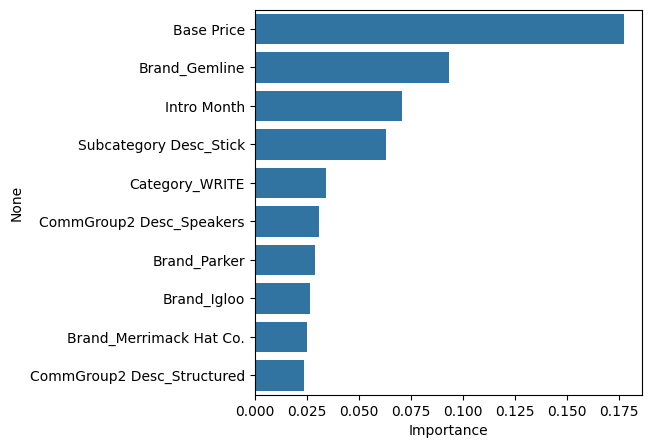

In [35]:
importances = q50.feature_importances_
columns=x_train.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(5,5))
sns.barplot(x=importance_df.Importance.head(10),y=importance_df.index[:10])

In [36]:
# --- Clean and merge ---
test_df_total_demand['Item'] = test_df_total_demand['Item'].astype(str).str.strip().str.upper()
df_total_demand_sku_attributes['Item'] = df_total_demand_sku_attributes['Item'].astype(str).str.strip().str.upper()

merged_test_df = pd.merge(
    test_df_total_demand,
    df_total_demand_sku_attributes,
    on='Item',
    how='inner'
).drop(columns=['Item'])

# --- Optional: reduce fragmentation from categorical columns ---
for col in merged_test_df.select_dtypes('object'):
    top_categories = merged_test_df[col].value_counts().nlargest(10).index
    merged_test_df[col] = np.where(merged_test_df[col].isin(top_categories), merged_test_df[col], 'Other')

# --- Create dummies consistent with training ---
x_test = pd.get_dummies(merged_test_df)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

print("Prepared test data shape:", x_test.shape)

Prepared test data shape: (173, 203)


/tmp/ipython-input-4232445436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_demand_sku_attributes['Item'] = df_total_demand_sku_attributes['Item'].astype(str).str.strip().str.upper()


In [37]:
# Predict the clusters for the test data
y_pred_q10 = q10.predict(x_test)
y_pred_q50 = q50.predict(x_test)
y_pred_q90 = q90.predict(x_test)


# Display the predictions
display(y_pred_q50[:10]) # Display first 10 predictions as an example

array([2101.40682299, 3624.75033299, 3624.75033299, 1608.26184214,
       1636.42119039, 5863.54667171, 3192.22026661, 3192.22026661,
       2543.00565537, 2543.00565537])

In [38]:
# Create a new DataFrame with Item, predicted cluster, and actual demand profile
total_demand_results_df = test_df_total_demand[['Item'] + ['Total Sales']].copy()
total_demand_results_df['Predicted demand (q10)'] = y_pred_q10
total_demand_results_df['Predicted demand (q50)'] = y_pred_q50
total_demand_results_df['Predicted demand (q90)'] = y_pred_q90

# Display the head of the new DataFrame
display(total_demand_results_df.head(50))

Item  Total Sales  Predicted demand (q10)  Predicted demand (q50)  \
0    100153-001         3231              533.736523             2101.406823   
1    100154-001         5959              533.736523             3624.750333   
2    100155-001         4939              533.736523             3624.750333   
7    100276-791         6435              320.859873             1608.261842   
9    100370-274         2143              533.736523             1636.421190   
24   100804-275         6796              801.733847             5863.546672   
37   101033-001         4653              801.733847             3192.220267   
38   101033-410         3687              801.733847             3192.220267   
47   101038-001         8973              801.733847             2543.005655   
48   101038-410        12079              801.733847             2543.005655   
54   101182-130         6204              533.736523             2963.080182   
58   101184-920         2698              533.736523             3624.750333   
59   101189-001         9854              746.431147             4676.919229   
62   101201-001         1917              199.709043             1500.667066   
72   101224-009         5003              533.736523             2101.406823   
73   101224-104         5464              533.736523             2101.406823   
81   101262-762         2792              746.431147             2491.600121   
85   101264-410          998              320.859873             1464.734568   
86   101265-001         3242              320.859873             1629.875984   
89   101265-938         1049              320.859873             1629.875984   
96   101285-000        16031              533.736523             8323.886792   
99   101290-130          631              461.716629              926.941152   
110  101319-001        11452             1122.344077             6626.572753   
117  101329-187           16               -8.917365              425.594896   
121  101330-187           45               87.567824              425.594896   
123  101331-183          561              172.585268             1102.525189   
126  101332-183         1259               88.463897             1102.525189   
128  101333-182        15666               88.463897              296.823518   
129  101333-192         6048               88.463897              296.823518   
131  101333-194           21               88.463897              296.823518   
135  101334-156          128               88.463897              611.667346   
136  101334-157          197               88.463897              611.667346   
137  101334-158            2               88.463897              611.667346   
140  101336-183           51              178.347937              129.700630   
141  101336-186            1              178.347937              129.700630   
149  101338-186         1603              357.511664             1302.198979   
150  101338-187          125              357.511664             1302.198979   
152  101340-182          518              357.511664             1302.198979   
155  101355-100         3497              421.708567             2187.105655   
164  101358-100         2851              421.708567             2187.105655   
167  101358-733          463              421.708567             2187.105655   
169  101361-100         1807              801.733847             2187.105655   
174  101364-181         2307              533.736523             1636.421190   
176  101374-184           33              -38.732597               -2.076014   
178  101375-184            2              -61.406302              425.594896   
181  101377-190          490               88.463897             1102.525189   
182  101383-001         4000              264.688756             3577.875516   
185  101408-214         2962              320.859873             1629.875984   
186  101412-373         2453              478.433823             1636.421190   
189  101413

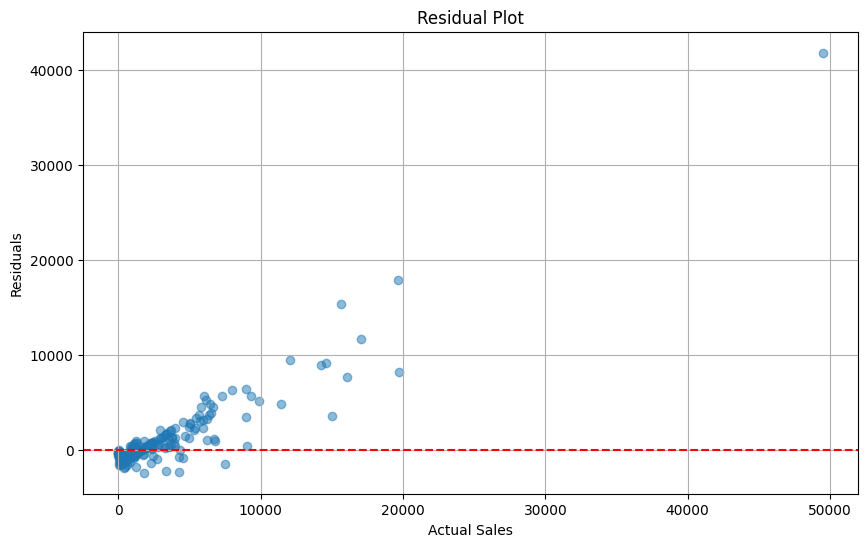

In [39]:
# Calculate residuals
total_demand_results_df['Residuals'] = total_demand_results_df['Total Sales'] - total_demand_results_df['Predicted demand (q50)']

# Create residual plot
plt.figure(figsize=(10, 6))
plt.scatter(total_demand_results_df['Total Sales'], total_demand_results_df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

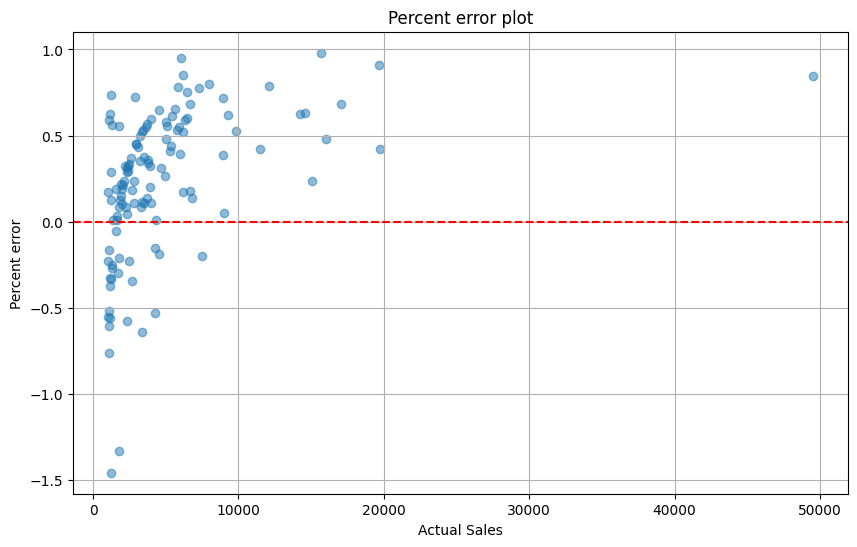

In [40]:
# Calculate residuals
total_demand_results_df['Percent error'] = (total_demand_results_df['Total Sales'] - total_demand_results_df['Predicted demand (q50)']) / total_demand_results_df['Total Sales']

# Filter data for sales above 5000
filtered_results_df = total_demand_results_df[total_demand_results_df['Total Sales'] > 1000].copy()

# Create residual plot using the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_results_df['Total Sales'], filtered_results_df['Percent error'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Percent error')
plt.title('Percent error plot')
plt.grid(True)
plt.show()

In [41]:
cols_to_drop = ['Total Sales', 'Residuals', 'Percent error']
existing_cols_to_drop = [col for col in cols_to_drop if col in total_demand_results_df.columns]
if existing_cols_to_drop:
    total_demand_results_df = total_demand_results_df.drop(columns=existing_cols_to_drop)
display(total_demand_results_df.head())

Item  Predicted demand (q10)  Predicted demand (q50)  \
0  100153-001              533.736523             2101.406823   
1  100154-001              533.736523             3624.750333   
2  100155-001              533.736523             3624.750333   
7  100276-791              320.859873             1608.261842   
9  100370-274              533.736523             1636.421190   

   Predicted demand (q90)  
0             5685.153346  
1             5685.153346  
2             5685.153346  
7             5058.436180  
9             5469.053346

# Monthly sales forecast

## Predicted

In [42]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q90)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q90)
high_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q90)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    high_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q90)']

# Display the head of the new DataFrame
display(high_monthly_sales_pred_df.head())

Item           1           2            3            4            5  \
0  101184-920   46.776855   69.796990   129.620073   588.723063   782.376107   
1  101182-130   76.143302  160.258585   817.386402   325.094847  1101.885505   
2  101033-001  162.308607  561.781067  1323.147501  1267.275506   453.269033   
3  101038-001   43.228878   73.002714   251.396641  1096.000422  1290.813792   
4  101285-000   54.845408  661.167163  1267.959663  3174.444703  2469.698011   

             6            7            8           9           10  \
0  1515.518130   262.669446   337.943950  527.611676  1129.358149   
1   631.666942   496.114795   448.090517  364.602519   232.828131   
2    82.875026    60.525612   230.541589  271.624818   560.052698   
3  1145.392685   463.001945   504.159120  626.139171   272.618833   
4  1554.547484  1316.422840  2072.708831  641.200700  1942.336776   

            11          12  
0   874.987732  354.061174  
1   737.061971  423.396426  
2   537.244756  589.595968  
3   252.422451  177.867847  
4  1682.399220  293.921727

In [43]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q50)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q50)
medium_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q50)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    medium_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q50)']

# Display the head of the new DataFrame
display(medium_monthly_sales_pred_df.head())

Item          1           2           3            4            5  \
0  101184-920  25.614604   38.220232   70.978839   322.379694   428.422438   
1  101182-130  38.802570   81.667657  416.539509   165.668095   561.520043   
2  101033-001  84.935124  293.976674  692.395177   663.157697   237.192975   
3  101038-001  17.742171   29.962069  103.179227   449.824928   529.781020   
4  101285-000  26.648157  321.246336  616.073241  1542.391681  1199.971026   

            6           7            8           9          10          11  \
0  829.884714  143.835533   185.055205  288.915623  618.426824  479.135768   
1  321.897009  252.819735   228.346598  185.801176  118.649044  375.606238   
2   43.368006   31.672691   120.641035  142.139643  293.072229  281.136969   
3  470.096700  190.027132   206.919026  256.982572  111.889324  103.600244   
4  755.319853  639.620415  1007.082862  311.545079  943.737997  817.440152   

           12  
0  193.880859  
1  215.762507  
2  308.532045  
3   73.001242  
4  142.809993

In [44]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q10)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q10)
low_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q10)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    low_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q10)']

# Display the head of the new DataFrame
display(low_monthly_sales_pred_df.head())

Item          1          2           3           4           5  \
0  101184-920   3.771694   5.627845   10.451478   47.469702   63.084263   
1  101182-130   6.989466  14.710709   75.030825   29.841620  101.146016   
2  101033-001  21.331662  73.832953  173.896725  166.553661   59.571590   
3  101038-001   5.593577   9.446147   32.529333  141.816385  167.024157   
4  101285-000   1.708708  20.598659   39.503275   98.899804   76.943426   

            6          7          8          9         10         11  \
0  122.198701  21.179466  27.248972  42.542191  91.061991  70.551689   
1   57.982970  45.540153  41.131833  33.468171  21.372128  67.657557   
2   10.891980   7.954673  30.299288  35.698715  73.605800  70.608230   
3  148.207471  59.909888  65.235398  81.018941  35.275367  32.662067   
4   48.431917  41.013145  64.575230  19.976604  60.513490  52.415137   

          12  
0  28.548530  
1  38.865074  
2  77.488570  
3  23.015114  
4   9.157130

## Actual

In [45]:
df_monthly_sales = pd.read_excel(file_path1)

display(df_monthly_sales.head())

Item Intro Date     1    2    3    4    5    6     7     8     9  \
0  100153-001 2024-01-01     4  148  635  209  484    1    16     0   490   
1  100154-001 2024-01-01   241  122  360  499  329  154  1728  1837   550   
2  100155-001 2024-01-01  1005   11    2    0    0  367   120   488  1003   
3  100176-777 2022-06-01     2  101  960  198  882  378   341    91   113   
4  100177-777 2022-06-01    11  369  863  639  459  114     0    96   650   

    10   11    12  
0  478    5   761  
1  132    6     1  
2  271  887   785  
3  209   84   172  
4  256  227  1051

## Visual

In [46]:
# Ensure required dataframes exist:
# test_df_total_demand, high_monthly_sales_pred_df, medium_monthly_sales_pred_df,
# low_monthly_sales_pred_df, df_monthly_sales

# --- 1️⃣ Prepare actual monthly sales dataframe ---
monthly_sales_actual = df_monthly_sales.copy()
demand_profile_columns = [i for i in range(1, 13)]
rename_dict = {month: f'Actual_{month}' for month in demand_profile_columns}
monthly_sales_actual.rename(columns=rename_dict, inplace=True)

# --- 2️⃣ Prepare predicted monthly sales dataframes with proper suffixes ---
high_df = high_monthly_sales_pred_df.copy()
high_df.rename(columns={month: f'{month}_q90' for month in demand_profile_columns}, inplace=True)

medium_df = medium_monthly_sales_pred_df.copy()
medium_df.rename(columns={month: f'{month}_q50' for month in demand_profile_columns}, inplace=True)

low_df = low_monthly_sales_pred_df.copy()
low_df.rename(columns={month: f'{month}_q10' for month in demand_profile_columns}, inplace=True)

# --- 3️⃣ Merge all datasets on 'Item' ---
plot_data = test_df_total_demand[['Item']].copy()
plot_data = (
    plot_data
    .merge(high_df, on='Item', how='left')
    .merge(medium_df, on='Item', how='left')
    .merge(low_df, on='Item', how='left')
    .merge(monthly_sales_actual[['Item'] + list(rename_dict.values())], on='Item', how='left')
)

# --- 4️⃣ Define columns for plotting ---
months = list(range(1, 13))
high_cols = [f'{m}_q90' for m in months]
medium_cols = [f'{m}_q50' for m in months]
low_cols = [f'{m}_q10' for m in months]
actual_cols = [f'Actual_{m}' for m in months]

# --- 5️⃣ Convert all relevant columns to numeric to prevent dtype issues ---
for col in high_cols + medium_cols + low_cols + actual_cols:
    plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')

# --- 6️⃣ Drop rows with missing or invalid data ---
all_plot_cols = high_cols + medium_cols + low_cols + actual_cols
plot_data_filtered = plot_data.dropna(subset=all_plot_cols).copy()

print(f"Number of items with complete data: {plot_data_filtered.shape[0]}")

# --- 7️⃣ Plot for each item with confidence interval ---
for _, item_data in plot_data_filtered.iterrows():
    item = item_data['Item']

    plt.figure(figsize=(8, 5))

    high = item_data[high_cols].astype(float).values
    medium = item_data[medium_cols].astype(float).values
    low = item_data[low_cols].astype(float).values
    actual = item_data[actual_cols].astype(float).values

    # Confidence interval (shaded area)
    plt.fill_between(months, low, high, color='skyblue', alpha=0.3, label='Predicted Range (q10–q90)')

    # Median prediction line
    plt.plot(months, medium, color='blue', linewidth=2, label='Predicted Median (q50)')

    # Actual sales line
    plt.plot(months, actual, color='black', marker='o', linewidth=2, label='Actual Sales')

    # Formatting
    plt.xlabel('Months since intro')
    plt.ylabel('Sales')
    plt.title(f'Monthly Sales Prediction vs Actual for Item: {item}')
    plt.xticks(months)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

Statistics for monthly sales

In [47]:
# Assuming plot_data_filtered DataFrame is available from the previous step
# and contains columns for actual sales and predicted quantiles (q10, q50, q90)
# with appropriate suffixes (e.g., 'Actual_1', '1_q10', '1_q90')

months = list(range(1, 13))
low_cols = [f'{m}_q10' for m in months]
high_cols = [f'{m}_q90' for m in months]
actual_cols = [f'Actual_{m}' for m in months]

# Initialize a counter for the number of actual values within the predicted range
within_range_count = 0
total_count = 0

# Iterate through each row (item) in the filtered data
for index, item_data in plot_data_filtered.iterrows():
    # Get the actual and predicted values for the current item across all months
    actual_values = item_data[actual_cols].values
    low_pred_values = item_data[low_cols].values
    high_pred_values = item_data[high_cols].values

    # Iterate through each month's data for the current item
    for month_index in range(len(months)):
        actual = actual_values[month_index]
        low_pred = low_pred_values[month_index]
        high_pred = high_pred_values[month_index]

        # Check if the actual value falls within the predicted range (inclusive)
        if low_pred <= actual <= high_pred:
            within_range_count += 1

        total_count += 1

# Calculate the percentage of actual values within the predicted range
percentage_within_range = (within_range_count / total_count) * 100 if total_count > 0 else 0

print(f"Percentage of actual monthly sales within the predicted range (q10-q90): {percentage_within_range:.2f}%")

Percentage of actual monthly sales within the predicted range (q10-q90): 41.43%


In [48]:
# Assuming plot_data_filtered DataFrame is available from the previous step
# and contains columns for actual sales and predicted quantiles (q10, q50, q90)
# with appropriate suffixes (e.g., 'Actual_1', '1_q10', '1_q90')

# Merge plot_data_filtered with SKU attributes to get category information
accuracy_by_group_df = pd.merge(plot_data_filtered, df_sku_attributes[['Item', 'Category', 'Sub-Category', 'CommGroup2 Desc']], on='Item', how='left')


months = list(range(1, 13))
low_cols = [f'{m}_q10' for m in months]
high_cols = [f'{m}_q90' for m in months]
actual_cols = [f'Actual_{m}' for m in months]

# Initialize dictionaries to store counts for each category, subcategory, and commgroup2
within_range_counts_by_category = {}
total_counts_by_category = {}
within_range_counts_by_subcategory = {}
total_counts_by_subcategory = {}
within_range_counts_by_commgroup2 = {}
total_counts_by_commgroup2 = {}


# Iterate through each row (item) in the filtered data
for index, item_data in accuracy_by_group_df.iterrows():
    item_category = item_data['Category']
    item_subcategory = item_data['Sub-Category']
    item_commgroup2 = item_data['CommGroup2 Desc']

    # Initialize counts for the category if not already present
    if item_category not in within_range_counts_by_category:
        within_range_counts_by_category[item_category] = 0
        total_counts_by_category[item_category] = 0

    # Initialize counts for the subcategory if not already present
    if item_subcategory not in within_range_counts_by_subcategory:
        within_range_counts_by_subcategory[item_subcategory] = 0
        total_counts_by_subcategory[item_subcategory] = 0

    # Initialize counts for the commgroup2 if not already present
    if item_commgroup2 not in within_range_counts_by_commgroup2:
        within_range_counts_by_commgroup2[item_commgroup2] = 0
        total_counts_by_commgroup2[item_commgroup2] = 0


    # Get the actual and predicted values for the current item across all months
    actual_values = item_data[actual_cols].values
    low_pred_values = item_data[low_cols].values
    high_pred_values = item_data[high_cols].values

    # Iterate through each month's data for the current item
    for month_index in range(len(months)):
        actual = actual_values[month_index]
        low_pred = low_pred_values[month_index]
        high_pred = high_pred_values[month_index]


        # Check if the actual value falls within the predicted range (inclusive)
        if low_pred <= actual <= high_pred:
            within_range_counts_by_category[item_category] += 1
            within_range_counts_by_subcategory[item_subcategory] += 1
            within_range_counts_by_commgroup2[item_commgroup2] += 1


        total_counts_by_category[item_category] += 1
        total_counts_by_subcategory[item_subcategory] += 1
        total_counts_by_commgroup2[item_commgroup2] += 1


# Calculate the percentage within range for each category
accuracy_by_category = {}
for category in total_counts_by_category:
    if total_counts_by_category[category] > 0:
        accuracy_by_category[category] = (within_range_counts_by_category[category] / total_counts_by_category[category]) * 100
    else:
        accuracy_by_category[category] = 0  # Handle cases with no data for a category

# Calculate the percentage within range for each subcategory
accuracy_by_subcategory = {}
for subcategory in total_counts_by_subcategory:
    if total_counts_by_subcategory[subcategory] > 0:
        accuracy_by_subcategory[subcategory] = (within_range_counts_by_subcategory[subcategory] / total_counts_by_subcategory[subcategory]) * 100
    else:
        accuracy_by_subcategory[subcategory] = 0  # Handle cases with no data for a subcategory

# Calculate the percentage within range for each commgroup2
accuracy_by_commgroup2 = {}
for commgroup2 in total_counts_by_commgroup2:
    if total_counts_by_commgroup2[commgroup2] > 0:
        accuracy_by_commgroup2[commgroup2] = (within_range_counts_by_commgroup2[commgroup2] / total_counts_by_commgroup2[commgroup2]) * 100
    else:
        accuracy_by_commgroup2[commgroup2] = 0  # Handle cases with no data for a commgroup2


# Convert the results to a pandas Series for easier display
accuracy_category_series = pd.Series(accuracy_by_category)
accuracy_subcategory_series = pd.Series(accuracy_by_subcategory)
accuracy_commgroup2_series = pd.Series(accuracy_by_commgroup2)


# Display the accuracy by Category with percentage formatting
print("Percentage of actual monthly sales within the predicted range (q10-q90) by Category:")
display(accuracy_category_series.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%'))

# Display the accuracy by Subcategory with percentage formatting
print("\nPercentage of actual monthly sales within the predicted range (q10-q90) by Subcategory:")
display(accuracy_subcategory_series.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%'))

# Display the accuracy by CommGroup2 with percentage formatting
print("\nPercentage of actual monthly sales within the predicted range (q10-q90) by CommGroup2 Desc:")
display(accuracy_commgroup2_series.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%'))

Percentage of actual monthly sales within the predicted range (q10-q90) by Category:


TOTE     56.82%
PKG      52.78%
UMBR     45.83%
OUTDR    45.83%
DUF      45.83%
HDWR     45.10%
HOME     44.87%
BACKP    42.86%
BLKTW    42.71%
DRINK    42.22%
STNRY    41.67%
WRITE    39.91%
COOL     39.58%
TECH     38.89%
SLWPK    30.00%
FOOD     25.93%
TRAVL    23.81%
OFFCE    16.67%
dtype: object


Percentage of actual monthly sales within the predicted range (q10-q90) by Subcategory:


1RLB     72.92%
1OTD     70.83%
1BAR     62.50%
1TRK     61.90%
1EVRD    60.00%
1ENTR    58.33%
1STRK    58.33%
1AXNT    58.33%
1FJR     54.17%
1GLF     51.67%
1COMM    50.00%
1WLNS    50.00%
1HDPR    50.00%
1DECR    50.00%
1ACC     50.00%
1WRT     50.00%
1PAPI    45.83%
1SND     44.44%
1HOME    43.75%
1AHYD    42.59%
1NTB     41.67%
1CAM     41.67%
1GFS     41.67%
1SPC     41.67%
1EHYD    40.83%
1CHRG    40.00%
1CFT     38.89%
1SFPR    38.33%
1TRV     38.10%
1CMPK    37.50%
1HDEV    37.50%
1KTCH    36.90%
1SFEV    36.11%
1EVT     36.11%
1CAP     33.33%
1STK     33.33%
1BPT     31.11%
1TRAC    30.56%
1ALLO    22.62%
1ORG     18.75%
1TACC    16.67%
1JNPD    16.67%
1SCNL    16.67%
1SPTF    12.50%
dtype: object


Percentage of actual monthly sales within the predicted range (q10-q90) by CommGroup2 Desc:


Specialty          75.00%
Towel              70.83%
Packable           66.67%
Coasters           66.67%
Lunch              66.67%
                    ...  
Tech Organizer     16.67%
Golf Towel         16.67%
Writing Pad        16.67%
Packing Cubes       8.33%
Quick Dry Towel     8.33%
Length: 67, dtype: object